In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler

# Set seed for reproducibility
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM public.updated_overall_cleaned_data;'
data = pd.read_sql(query, con=engine)

# Updated selected columns
selected_columns = [
    'policy no', 'policy start date', 'policy end date', 'biztype', 'tie up', 'variant', 'Cleaned Reg no', 'updated_old_policy_no', 'model',
    'rto location', 'product name', 'Cleaned Branch Name 2', 'Renewal Rate Status',
    'Cleaned State2', 'discount_level', 'cleaned new vertical', 'purchase_type',
    'manufacturer/make', 'tie_up_category', 'make_category', 'Cleaned Zone 2',
    'corrected_name', 'payement_level', 'New Customers', 'fuel type', 'customerid',
    'add-on_level', 'vertical_category', 'vehicle segment', 'idv_level', 'vehicle_type',
    'Claim Status', 'Claim Happaned/Not', 'Area Type', 'ncb % previous year',
    'total od premium', 'applicable discount with ncb', 'policy_wise_purchase',
    'new_chain_flag', 'firstpolicyyear', 'age', 'total tp premium', 'total premium payable',
    'gst', 'vehicle idv', 'Policy Tenure', 'chain_group', 'Number of claims', 'denied',
    'approved', 'Cumulative Tenure (Months)', 'Tenure Decimal', 'Customer Tenure',
    'before gst add-on gwp', 'Policy Status'
]

data = data[selected_columns]

# Remove rows where 'Policy Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]

data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

# Convert date columns to datetime
date_columns = ['policy start date', 'policy end date']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

# Splitting the data with a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [2]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [3]:
# Generate 7 different undersampled datasets while keeping the minority class constant
undersampled_sets = {}
for i in range(7):
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=i)  
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    undersampled_sets[f'set_{i+1}'] = (X_resampled, y_resampled)

# Access specific undersampled sets
X_train_1, y_train_1 = undersampled_sets["set_1"]
X_train_2, y_train_2 = undersampled_sets["set_2"]
X_train_3, y_train_3 = undersampled_sets["set_3"]
X_train_4, y_train_4 = undersampled_sets["set_4"]
X_train_5, y_train_5 = undersampled_sets["set_5"]
X_train_6, y_train_6 = undersampled_sets["set_6"]
X_train_7, y_train_7 = undersampled_sets["set_7"]

In [4]:
# Print count of 0s and 1s in each undersampled set
for i in range(1, 8):
    _, y_resampled = undersampled_sets[f'set_{i}']
    print(f"Set {i}:\n{y_resampled.value_counts()}\n")

Set 1:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 2:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 3:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 4:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 5:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 6:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 7:
Policy Status
0    388763
1    388763
Name: count, dtype: int64



In [5]:
# Print count of 0s and 1s in X_train and y_train
print("Training Set Counts:")
print(y_train.value_counts())
print()

# Print count of 0s and 1s in X_test and y_test
print("Test Set Counts:")
print(y_test.value_counts())
print()

Training Set Counts:
Policy Status
1    663346
0    388763
Name: count, dtype: int64

Test Set Counts:
Policy Status
1    284292
0    166613
Name: count, dtype: int64



Test Accuracy: 0.6521440214679367
Test Log Loss: 0.6142075288417621
Test ROC AUC: 0.7234366146389619
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209161349954686
Class 1 Test Accuracy: 0.6118392357153912


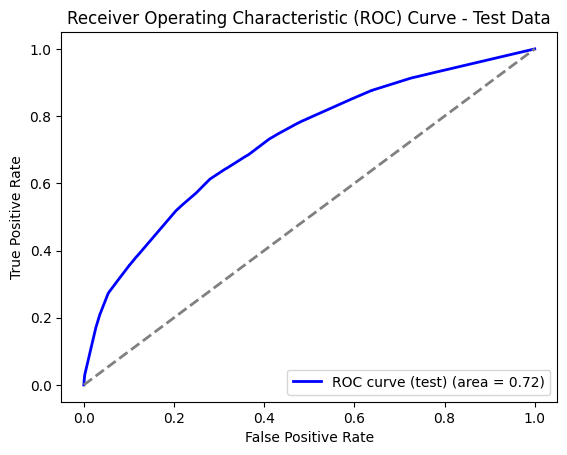

Train Accuracy: 0.6619741870851784
Train Log Loss: 0.6097903653897697
Train ROC AUC: 0.725821522034914
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7013990528934081
Class 1 Train Accuracy: 0.6388687050197032


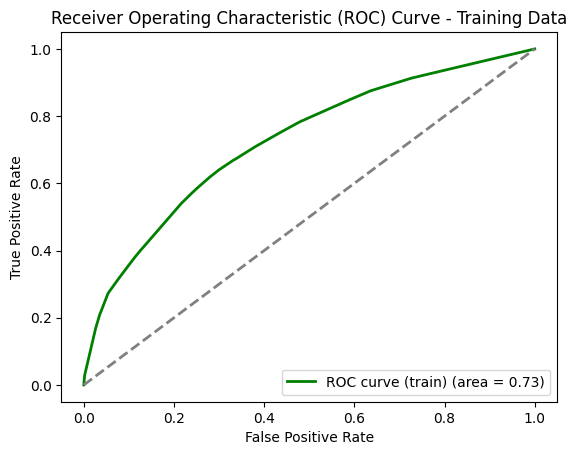

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Make predictions using each trained model (Test Data)
ensemble_predictions = []
ensemble_proba_predictions = []
for model in models.values():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(y_pred)
    ensemble_proba_predictions.append(y_pred_proba)

# Compute final ensemble prediction (majority vote)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_proba_predictions = np.array(ensemble_proba_predictions)

y_pred_ensemble = np.round(np.mean(ensemble_predictions, axis=0))  # Majority vote
y_pred_ensemble_proba = np.mean(ensemble_proba_predictions, axis=0)  # Average probability

# Evaluate the ensemble model on test data
accuracy = accuracy_score(y_test, y_pred_ensemble)
log_loss_value = log_loss(y_test, y_pred_ensemble_proba)
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
report = classification_report(y_test, y_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Test Data)
conf_matrix_test = confusion_matrix(y_test, y_pred_ensemble)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Print Test Evaluation Results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ====== OPTIONAL: Training Set Evaluation (if needed) ======

# Make predictions on training data using ensemble
ensemble_train_predictions = []
ensemble_train_proba_predictions = []
for model in models.values():
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    ensemble_train_predictions.append(y_train_pred)
    ensemble_train_proba_predictions.append(y_train_pred_proba)

# Compute final ensemble prediction (majority vote) for training data
y_train_pred_ensemble = np.round(np.mean(ensemble_train_predictions, axis=0))
y_train_pred_ensemble_proba = np.mean(ensemble_train_proba_predictions, axis=0)

# Evaluate the ensemble model on training data
train_accuracy = accuracy_score(y_train, y_train_pred_ensemble)
train_log_loss = log_loss(y_train, y_train_pred_ensemble_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_ensemble_proba)
train_report = classification_report(y_train, y_train_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Training Data)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_ensemble)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print Training Evaluation Results
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_ensemble_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6573446734899813
Test Log Loss: 0.608805097960862
Test ROC AUC: 0.7873617217601271
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.87      0.65    166613
           1       0.87      0.54      0.66    284292

    accuracy                           0.66    450905
   macro avg       0.70      0.70      0.66    450905
weighted avg       0.74      0.66      0.66    450905

Class 0 Test Accuracy: 0.8656707459802057
Class 1 Test Accuracy: 0.5352524868796871


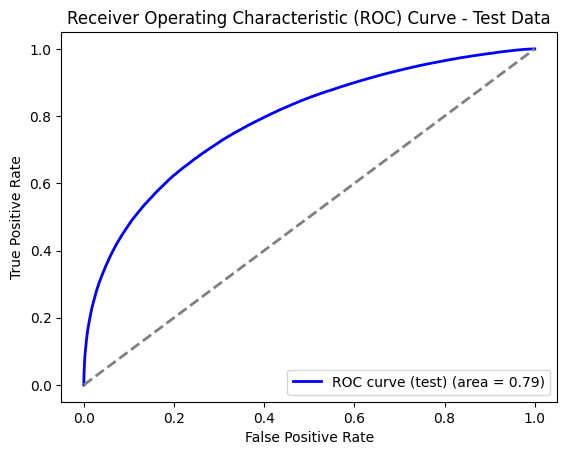

Train Accuracy: 0.6478188096480497
Train Log Loss: 0.63032868012085
Train ROC AUC: 0.7902019008164765
Train Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.90      0.65    388763
           1       0.89      0.50      0.64    663346

    accuracy                           0.65   1052109
   macro avg       0.70      0.70      0.65   1052109
weighted avg       0.75      0.65      0.65   1052109

Class 0 Train Accuracy: 0.8956176385098377
Class 1 Train Accuracy: 0.5025929153111649


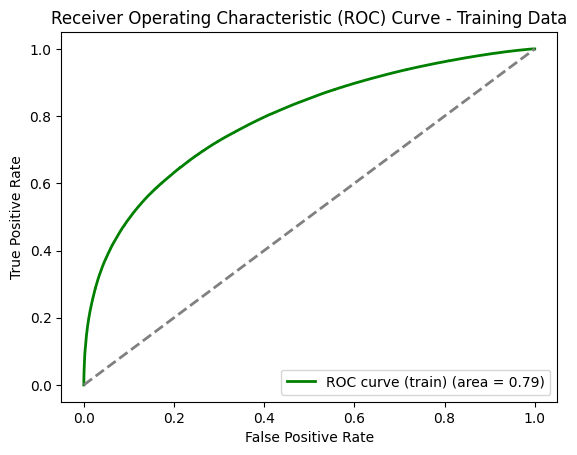

In [9]:
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Make predictions using each trained model (Test Data)
ensemble_predictions = []
ensemble_proba_predictions = []
for model in models.values():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(y_pred)
    ensemble_proba_predictions.append(y_pred_proba)

# Compute final ensemble prediction (majority vote)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_proba_predictions = np.array(ensemble_proba_predictions)

y_pred_ensemble = np.round(np.mean(ensemble_predictions, axis=0))  # Majority vote
y_pred_ensemble_proba = np.mean(ensemble_proba_predictions, axis=0)  # Average probability

# Evaluate the ensemble model on test data
accuracy = accuracy_score(y_test, y_pred_ensemble)
log_loss_value = log_loss(y_test, y_pred_ensemble_proba)
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
report = classification_report(y_test, y_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Test Data)
conf_matrix_test = confusion_matrix(y_test, y_pred_ensemble)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Print Test Evaluation Results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ====== OPTIONAL: Training Set Evaluation (if needed) ======

# Make predictions on training data using ensemble
ensemble_train_predictions = []
ensemble_train_proba_predictions = []
for model in models.values():
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    ensemble_train_predictions.append(y_train_pred)
    ensemble_train_proba_predictions.append(y_train_pred_proba)

# Compute final ensemble prediction (majority vote) for training data
y_train_pred_ensemble = np.round(np.mean(ensemble_train_predictions, axis=0))
y_train_pred_ensemble_proba = np.mean(ensemble_train_proba_predictions, axis=0)

# Evaluate the ensemble model on training data
train_accuracy = accuracy_score(y_train, y_train_pred_ensemble)
train_log_loss = log_loss(y_train, y_train_pred_ensemble_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_ensemble_proba)
train_report = classification_report(y_train, y_train_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Training Data)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_ensemble)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print Training Evaluation Results
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_ensemble_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7107084640888879
Test Log Loss: 0.5473243515485761
Test ROC AUC: 0.7871154651091056
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65    166613
           1       0.81      0.71      0.76    284292

    accuracy                           0.71    450905
   macro avg       0.70      0.71      0.70    450905
weighted avg       0.73      0.71      0.72    450905

Class 0 Test Accuracy: 0.7158505038622437
Class 1 Test Accuracy: 0.7076949052382762


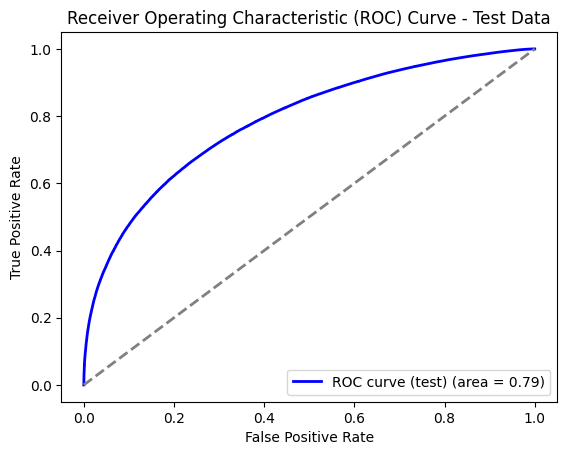

Train Accuracy: 0.7051066001716553
Train Log Loss: 0.5528008643762589
Train ROC AUC: 0.7902031373395987
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66    388763
           1       0.83      0.67      0.74    663346

    accuracy                           0.71   1052109
   macro avg       0.70      0.72      0.70   1052109
weighted avg       0.73      0.71      0.71   1052109

Class 0 Train Accuracy: 0.7612607166834292
Class 1 Train Accuracy: 0.6721967118215834


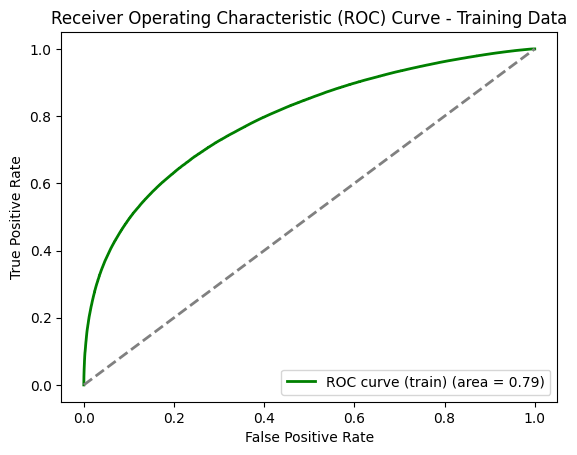

In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Make predictions using each trained model (Test Data)
ensemble_predictions = []
ensemble_proba_predictions = []
for model in models.values():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(y_pred)
    ensemble_proba_predictions.append(y_pred_proba)

# Compute final ensemble prediction (majority vote)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_proba_predictions = np.array(ensemble_proba_predictions)

y_pred_ensemble = np.round(np.mean(ensemble_predictions, axis=0))  # Majority vote
y_pred_ensemble_proba = np.mean(ensemble_proba_predictions, axis=0)  # Average probability

# Evaluate the ensemble model on test data
accuracy = accuracy_score(y_test, y_pred_ensemble)
log_loss_value = log_loss(y_test, y_pred_ensemble_proba)
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
report = classification_report(y_test, y_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Test Data)
conf_matrix_test = confusion_matrix(y_test, y_pred_ensemble)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Print Test Evaluation Results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ====== OPTIONAL: Training Set Evaluation (if needed) ======

# Make predictions on training data using ensemble
ensemble_train_predictions = []
ensemble_train_proba_predictions = []
for model in models.values():
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    ensemble_train_predictions.append(y_train_pred)
    ensemble_train_proba_predictions.append(y_train_pred_proba)

# Compute final ensemble prediction (majority vote) for training data
y_train_pred_ensemble = np.round(np.mean(ensemble_train_predictions, axis=0))
y_train_pred_ensemble_proba = np.mean(ensemble_train_proba_predictions, axis=0)

# Evaluate the ensemble model on training data
train_accuracy = accuracy_score(y_train, y_train_pred_ensemble)
train_log_loss = log_loss(y_train, y_train_pred_ensemble_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_ensemble_proba)
train_report = classification_report(y_train, y_train_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Training Data)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_ensemble)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print Training Evaluation Results
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_ensemble_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6431487785675475
Test Log Loss: 0.6250341660429799
Test ROC AUC: 0.7833063130841237
Test Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.88      0.65    166613
           1       0.88      0.50      0.64    284292

    accuracy                           0.64    450905
   macro avg       0.69      0.69      0.64    450905
weighted avg       0.74      0.64      0.64    450905

Class 0 Test Accuracy: 0.8821640568262981
Class 1 Test Accuracy: 0.5030707863745726


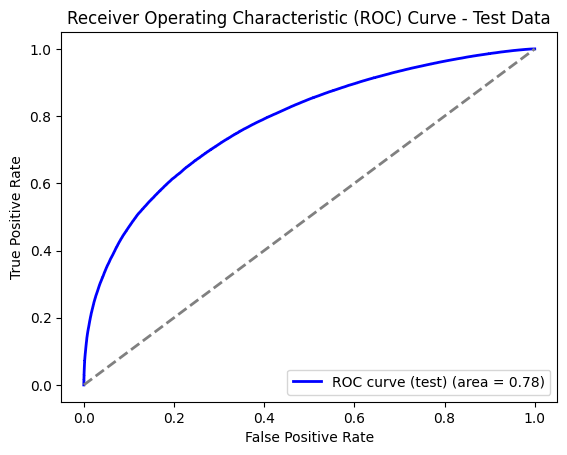

Train Accuracy: 0.6392731171390037
Train Log Loss: 0.6386632096751176
Train ROC AUC: 0.7835942661221782
Train Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.90      0.65    388763
           1       0.89      0.49      0.63    663346

    accuracy                           0.64   1052109
   macro avg       0.70      0.69      0.64   1052109
weighted avg       0.75      0.64      0.64   1052109

Class 0 Train Accuracy: 0.8951546314849922
Class 1 Train Accuracy: 0.4893102543770521


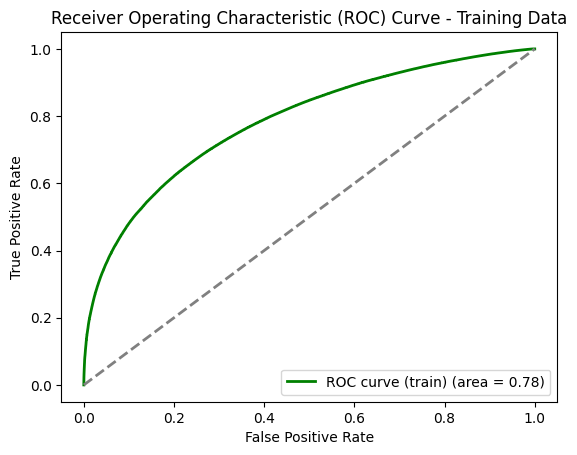

In [11]:
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                    
    random_state=42
)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Make predictions using each trained model (Test Data)
ensemble_predictions = []
ensemble_proba_predictions = []
for model in models.values():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(y_pred)
    ensemble_proba_predictions.append(y_pred_proba)

# Compute final ensemble prediction (majority vote)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_proba_predictions = np.array(ensemble_proba_predictions)

y_pred_ensemble = np.round(np.mean(ensemble_predictions, axis=0))  # Majority vote
y_pred_ensemble_proba = np.mean(ensemble_proba_predictions, axis=0)  # Average probability

# Evaluate the ensemble model on test data
accuracy = accuracy_score(y_test, y_pred_ensemble)
log_loss_value = log_loss(y_test, y_pred_ensemble_proba)
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
report = classification_report(y_test, y_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Test Data)
conf_matrix_test = confusion_matrix(y_test, y_pred_ensemble)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Print Test Evaluation Results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ====== OPTIONAL: Training Set Evaluation (if needed) ======

# Make predictions on training data using ensemble
ensemble_train_predictions = []
ensemble_train_proba_predictions = []
for model in models.values():
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    ensemble_train_predictions.append(y_train_pred)
    ensemble_train_proba_predictions.append(y_train_pred_proba)

# Compute final ensemble prediction (majority vote) for training data
y_train_pred_ensemble = np.round(np.mean(ensemble_train_predictions, axis=0))
y_train_pred_ensemble_proba = np.mean(ensemble_train_proba_predictions, axis=0)

# Evaluate the ensemble model on training data
train_accuracy = accuracy_score(y_train, y_train_pred_ensemble)
train_log_loss = log_loss(y_train, y_train_pred_ensemble_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_ensemble_proba)
train_report = classification_report(y_train, y_train_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Training Data)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_ensemble)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print Training Evaluation Results
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_ensemble_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6776394140672647
Test Log Loss: 0.6054251919811935
Test ROC AUC: 0.7507542785769123
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.72      0.62    166613
           1       0.80      0.65      0.72    284292

    accuracy                           0.68    450905
   macro avg       0.67      0.69      0.67    450905
weighted avg       0.71      0.68      0.68    450905

Class 0 Test Accuracy: 0.7211922238960945
Class 1 Test Accuracy: 0.6521147271115614


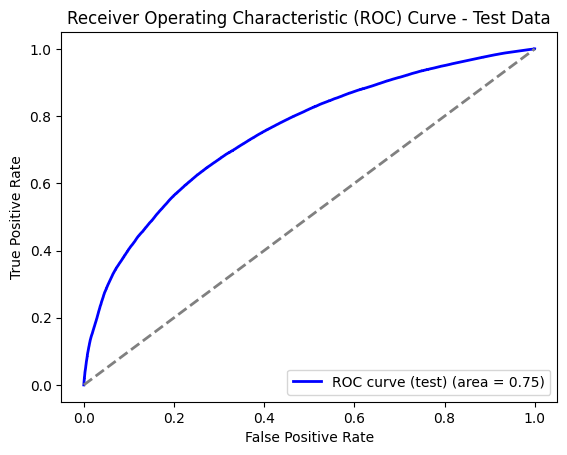

Train Accuracy: 0.6790693739907177
Train Log Loss: 0.6016854857995644
Train ROC AUC: 0.7513540483865238
Train Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.72      0.62    388763
           1       0.80      0.66      0.72    663346

    accuracy                           0.68   1052109
   macro avg       0.67      0.69      0.67   1052109
weighted avg       0.71      0.68      0.68   1052109

Class 0 Train Accuracy: 0.7189624527025463
Class 1 Train Accuracy: 0.6556894893464346


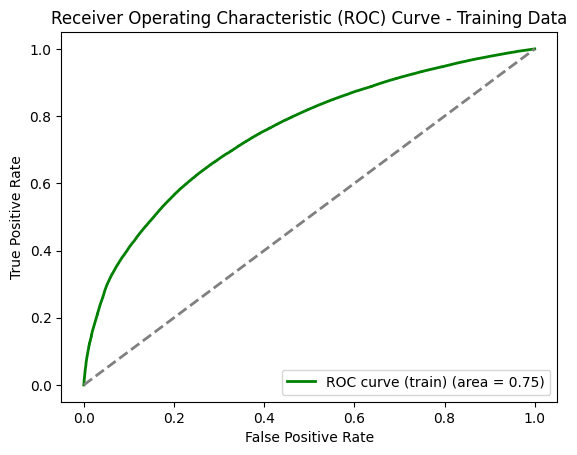

In [12]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = RandomForestClassifier(
    n_estimators=100,             
    max_depth=8,                  
    min_samples_split=20,         
    min_samples_leaf=10,          
    max_leaf_nodes=50,            
    class_weight='balanced',      
    random_state=42
)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Make predictions using each trained model (Test Data)
ensemble_predictions = []
ensemble_proba_predictions = []
for model in models.values():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(y_pred)
    ensemble_proba_predictions.append(y_pred_proba)

# Compute final ensemble prediction (majority vote)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_proba_predictions = np.array(ensemble_proba_predictions)

y_pred_ensemble = np.round(np.mean(ensemble_predictions, axis=0))  # Majority vote
y_pred_ensemble_proba = np.mean(ensemble_proba_predictions, axis=0)  # Average probability

# Evaluate the ensemble model on test data
accuracy = accuracy_score(y_test, y_pred_ensemble)
log_loss_value = log_loss(y_test, y_pred_ensemble_proba)
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
report = classification_report(y_test, y_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Test Data)
conf_matrix_test = confusion_matrix(y_test, y_pred_ensemble)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Print Test Evaluation Results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ====== OPTIONAL: Training Set Evaluation (if needed) ======

# Make predictions on training data using ensemble
ensemble_train_predictions = []
ensemble_train_proba_predictions = []
for model in models.values():
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    ensemble_train_predictions.append(y_train_pred)
    ensemble_train_proba_predictions.append(y_train_pred_proba)

# Compute final ensemble prediction (majority vote) for training data
y_train_pred_ensemble = np.round(np.mean(ensemble_train_predictions, axis=0))
y_train_pred_ensemble_proba = np.mean(ensemble_train_proba_predictions, axis=0)

# Evaluate the ensemble model on training data
train_accuracy = accuracy_score(y_train, y_train_pred_ensemble)
train_log_loss = log_loss(y_train, y_train_pred_ensemble_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_ensemble_proba)
train_report = classification_report(y_train, y_train_pred_ensemble)

# Confusion Matrix & Class-Specific Accuracy (Training Data)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_ensemble)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print Training Evaluation Results
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_ensemble_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()